# Models and packages

This notebook shows how to

* structure models in packages,
* load models that are part of packages,
* simulate the models

In [5]:
import os
from pymodelica import compile_fmu
from pyfmi import load_fmu
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
from matplotlib import pyplot as plt
import numpy as np

## Modelica packages

If you work with Modelica you should be familiar with packages.
Packages are a way to organize and structure your models. If you have a look
at the Modelica Standard Library [MSL](https://github.com/modelica/Modelica)
you'll notice that it's a collections of models and functions structured in packages.

Packages can be defined within a single `*.mo` file, otherwise they can be a collection of
folders and files. The latter mechanism is preferred because it's easier to manage
many small files rather a very large one, also, it's easier to track changes using a
version control system, especially when working in a team.

## Structuring models in packages

The folder `modelica` that is included in the [ModelicaInAction](https://github.com/mbonvini/ModelicaInAction)
repository contains a package called **`SimpleElectrical`**.

The package contains a collections of models representing basic electric components.
Most of the components in this library were introduced in this article 
[SW engineering meets mathematical modeling - Types and Objects](http://marcobonvini.com/modelica/2016/10/23/modelica-sw-engineering-meets-math-modeling-types-and-objects.html).

The folder `ModelicaInAction/modelica` contains the package **`SimpleElectrical`**.
If we run the following commands

```
cd ModelicaInAction
tree -L 3 ./modelica/
```

we can see the structure of the package

```
./modelica/
├── HelloWorld.mo
└── SimpleElectrical    
    ├── package.mo      
    ├── package.order 
    ├── Connectors
    │   ├── Terminal.mo
    │   ├── package.mo
    │   └── package.order
    ├── Interfaces
    │   ├── Bipole.mo
    │   ├── package.mo
    │   └── package.order
    ├── Components
    │   ├── Capacitor.mo
    │   ├── Ground.mo
    │   ├── Inductor.mo
    │   ├── Resistor.mo
    │   ├── Source.mo
    │   ├── package.mo
    │   └── package.order
    └── Examples
        ├── RC.mo
        ├── package.mo
        └── package.order
```

Each folder containing the files `package.{mo,order}` is a package. The file `package.mo` contains the actual
content of the package, while the file `package.order` defines the order of the elements within the package.
Packages can contain other sub-packages.

A good design principle is to group models that have similar characteristics
in sub-packages. For example in our case the **`SimpleElectrical`** package contains four sub-packages

* `Connectors` contains the definition of the connectors used to connect components in the library,
* `Interfaces` contains the definition of abstract extendable models,
* `Components` contains the main electrical components such as resistances, capacitances, etc.
* `Examples` contains a list of examples that showcase the use of the library.

The Modelica language specification doesn't prescribe how packages should be called, however the names
I used are a de-facto standard when working with Modelica libraries.

## Anatomy of a package

Let's have a look at the code inside the files in order to fully understand how packages work.
At the top level we have the following structure of files and folders

```
./modelica/
└── SimpleElectrical   <== Root-package (a folder) 
    ├── package.mo      
    ├── package.order 
    ├── Connectors     <== Sub-package (a folder)
    ├── Interfaces     <== Sub-package (a folder)
    ├── Components     <== Sub-package (a folder)
    └── Examples       <== Sub-package (a folder)
```

This is the content of the file `SimpleElectrical/package.mo`

```
within ;
package SimpleElectrical
  "Modelica electrical package for educational purposes"
end SimpleElectrical;
```

The first line contains the keyword `within` followed by a white space, this indicates that
the file is not part of any sub-package. The remaining lines contain the declaration of the
package **`SimpleElectrical`**. Please note that the name of the packages has to match the name
of the folder containing it.

We know that the package contains four sub-packages, and each one is represented by a
folder. A Modelica tool that visualizes the hierarchy of models and pacakges needs to know
in which order display them. This is the role of the file `SimpleElectrical/package.order`.
The file contains an ordered list of the sub-packages contained by the root-level package.

In our case the content of `SimpleElectrical/package.order` is

```
Connectors
Interfaces
Components
Examples
```

So far we've seen the structure of the top level package. But how do sub-packages work?
Let's have a look at the sub-package **`Components`**.

```
./modelica/
└── SimpleElectrical    
    ├── package.mo      
    ├── package.order 
    ...
    ├── Components
    │   ├── package.mo
    │   ├── package.order
    │   ├── Ground.mo
    │   ├── Resistor.mo
    │   ├── Source.mo
    │   ├── Capacitor.mo
    │   └── Inductor.mo
    ...
```

Again, the folder `SimpleElectrical/Components` (that has the same name of the sub-package)
contains the files `package.{mo,order}`. However, in this case the folder contains other 
`*.mo` files such as `Ground.mo`, `Resistor.mo`, etc. These files are the actual content of the
sub-package.

The content of the file `SimpleElectrical/Components.package.mo` is

```
within SimpleElectrical;
package Components
  "Package containing the electrical model
  components"
end Components;
```

In this case **`Components`** is a sub-package, therefore the first line states that it is part of the
parent package **`SimpleElectrical`**. The following lines declare the sub-package.
The models contained in this package are the remaining `*.mo` files.
Let's have a look at `Source.mo`

```
within SimpleElectrical.Components;

model Source
  extends SimpleElectrical.Interfaces.Bipole;
  parameter Modelica.SIunits.Voltage E = 10
    "Constant voltage source";
equation
  // The source generates a voltage difference
  // between the two terminals
  V = E;
end Source;
```

The first line declares that this model is part of the package **`SimpleElectrical.Components`**,
while the following lines declare the model.
Again the name of the model matches the name of the file in the file system.

As we have seen before, the folder contains a file called `package.order` that defines the order of the
models within the package. The content of `SimpleElectrical/Components/package.order` is

```
Ground
Source
Resistor
Capacitor
Inductor
```

## Using the package

OK, now that we know everything about packages and their structure, let's see how to use the models
they contain. For example we're interested in simulating the model **`SimpleElectrical/Examples/RC.mo`**.

In order to simulate the model we have to inform the compiler of the existence of this new
library `SimpleElectrical`. This can be accomplished in two ways:

* adding the path containing the library to the environmental variable `MODELICAPATH`,
* specifying the location of the library when compiling the model.

In this case the docker image is built using the following command

```
ENV MODELICAPATH /home/docker/installed/JModelica/ThirdParty/MSL:/home/docker/modelica
```

that adds the path `/home/docker/modelica` to the environmental variable `MODELICAPATH`.
Thanks to this the compiler will be able to automatically  find the package `SimpleElectrical`.
We can verify this at runtime by checking the value of this environmental variable

In [6]:
package_root_path = "/home/developer/modelica"
msg = "The path {} is missing from the environmental variable MODELICAPATH".format(
    package_root_path
)
print "MODELICAPATH = {}".format(os.environ["MODELICAPATH"])
assert package_root_path in os.environ["MODELICAPATH"].split(":"), msg

MODELICAPATH = /usr/local/JModelica/ThirdParty/MSL:/home/developer/modelica


## Load and simulate

Once the `MODELICAPATH` is set, we can specify the model we'd like to compiled and simulate using the dot notation.
For example the model we want to simulate is located in package `SimpleElectrical => Examples` and its name is `RC`.
Using the dot notation this becomes **`SimpleElectrical.Examples.RC`**.

In [7]:
# Compile the model and save the return argument, which is the file name of the FMU
rc_example_fmu = compile_fmu("SimpleElectrical.Examples.RC")

# Load the model and simulate
rc_example = load_fmu(rc_example_fmu)
res = rc_example.simulate(final_time=0.1)

Final Run Statistics: --- 

 Number of steps                                 : 46
 Number of function evaluations                  : 69
 Number of Jacobian evaluations                  : 2
 Number of function eval. due to Jacobian eval.  : 2
 Number of error test failures                   : 2
 Number of nonlinear iterations                  : 65
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 0.0001

Simulation interval    : 0.0 - 0.1 seconds.
Elapsed simulation time: 0.00373792648315 seconds.


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/local/JModelica/Python/pymodelica/compiler_logging.py", line 218, in run
    xml.sax.parse(self.stream, LogErrorParser(self.result))
  File "/usr/lib/python2.7/xml/sax/__init__.py", line 33, in parse
    parser.parse(source)
  File "/usr/lib/python2.7/xml/sax/expatreader.py", line 116, in parse
    self._close_source()
  File "/usr/lib/python2.7/xml/sax/expatreader.py", line 235, in _close_source
    file.close()
AttributeError: KeepLastStream instance has no attribute 'close'



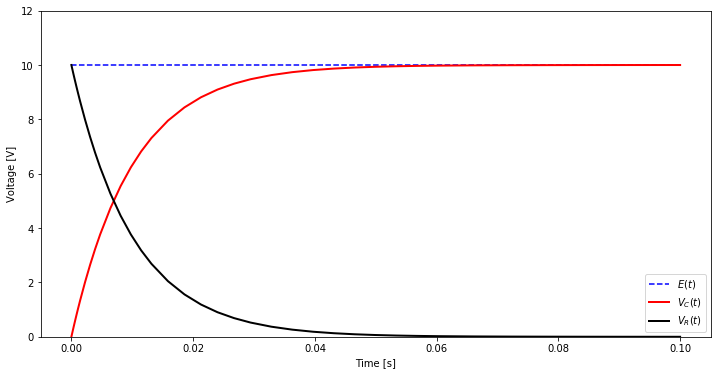

In [8]:
plt.plot(res["time"], res['S.V'], 'b--', label="$E(t)$")
plt.plot(res["time"], res['C.V'], 'r', label="$V_C(t)$", linewidth=2)
plt.plot(res["time"], res['R.V'], 'K', label="$V_R(t)$", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.ylim([0.0, 12.0])
plt.legend()